In [1]:
import qrcode
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import matplotlib.patches as mpatches
import requests
from matplotlib.lines import Line2D
import math
import contextily as ctx
import rasterio
from rasterio.plot import show
import collections
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from descartes import PolygonPatch
import os
import collections

from pykml import parser
import re
from shapely.geometry import LineString
from pyproj import CRS

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
idd = 24

In [3]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [4]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [5]:
path_shp_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_shp_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_shp_recorridos = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\RECORRIDOS.shp'
path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

In [6]:
gdf_plan = gpd.read_file(path_shp_plan)
gdf_cat = gpd.read_file(path_shp_cat)
gdf_recorridos = gpd.read_file(path_shp_recorridos)
df_parte = pd.read_excel(path_xlsx_parte)

In [7]:
def generar_plano_pulv(shp_prop, shp_plan, shp_recorrido, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
    
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_plan.plot(ax=ax, edgecolor='yellow', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_recorrido.plot(ax=ax, color='red', linewidth=0.5, linestyle="-", label="Líneas")

    # Agregar etiquetas con lote mas area
    for idx, row in shp_plan.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))

    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])

    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes Propiedad'),
        Patch(facecolor=(0, 0, 0, 0), edgecolor='yellow', label='Lotes Aplicados'),
        # Líneas (Caminos, canales, etc.)
        Line2D([0], [0], color='red', linewidth=1, linestyle="-", label='Recorrido de Dron'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_plano, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [9]:
parte = df_parte[df_parte['idd']==idd]
shp_recorrido = gdf_recorridos[gdf_recorridos['idd']==idd]
plan = gdf_plan[gdf_plan['idd']==idd]

cod_prop = parte['COD PROPIEDAD'].iloc[0]

prop = gdf_cat[gdf_cat['unidad_01'] == cod_prop]
path_plano = unidad + r"\OneDrive - Ingenio Azucarero Guabira S.A\_DATOS_PYTHON\planos\plano_aux_pulverizacion.jpg"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"

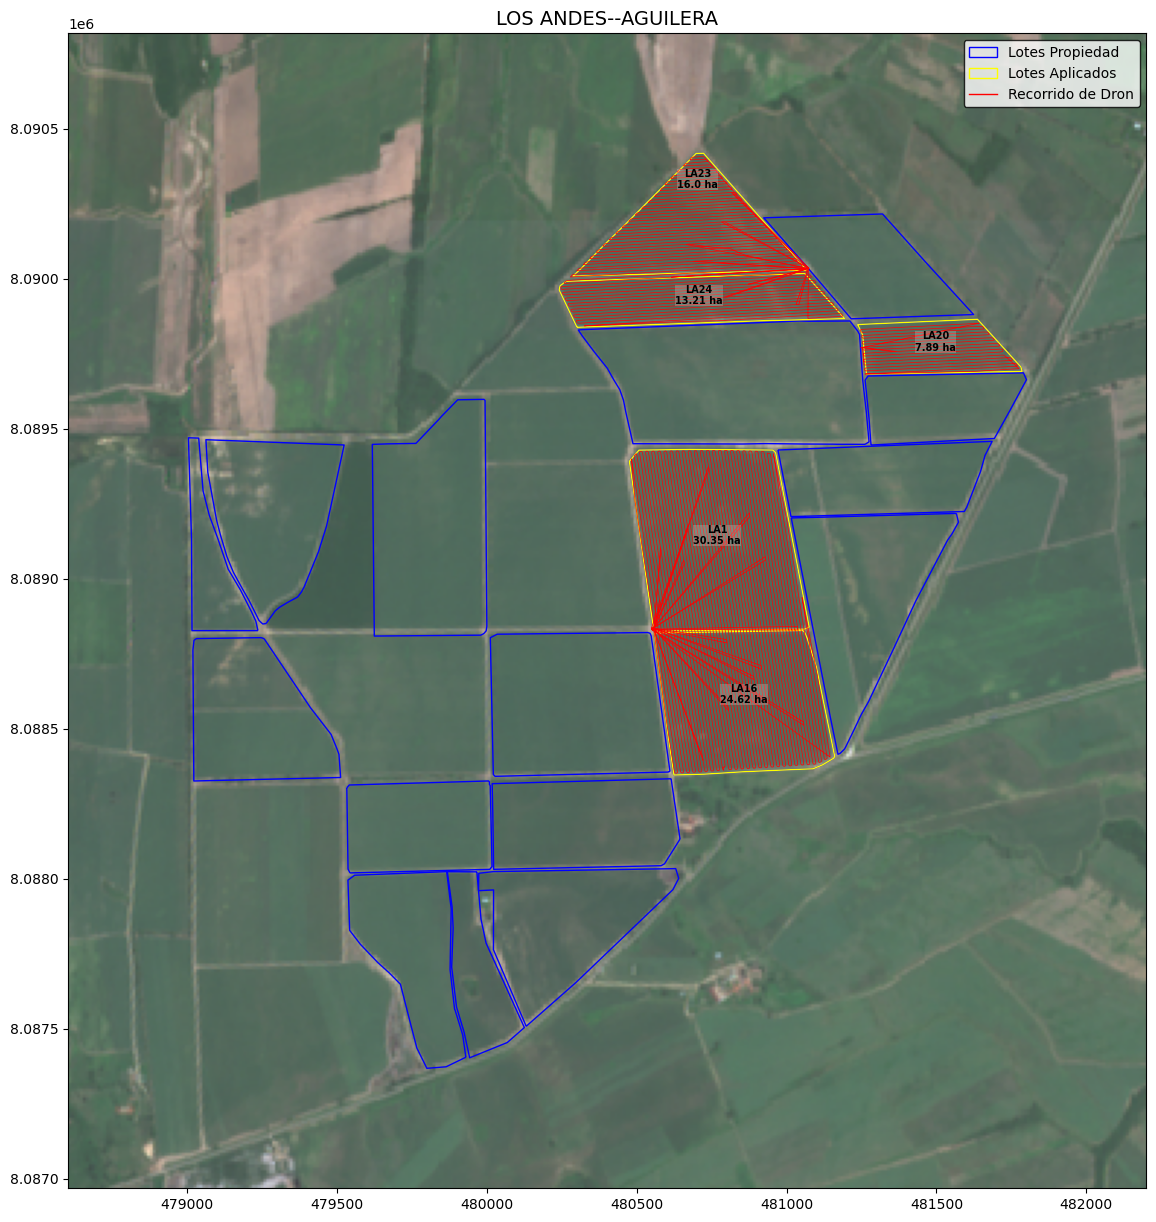

In [10]:
generar_plano_pulv(prop, plan, shp_recorrido, path_tif, path_plano)

In [11]:
fecha = parte['FECHA'].iloc[0]

In [12]:
data = {
    'n_labor': str(parte['Nº DE LABOR'].iloc[0]), 
    'fecha' : parte['FECHA'].iloc[0].strftime("%d-%m-%Y"),
    'nom_ca' : parte['NOMBRE CANERO'].iloc[0],
    'cod_ca' : parte['COD CANERO'].iloc[0],
    'nom_prop' : parte['NOMBRE PROPIEDAD'].iloc[0],
    'cod_prop' : parte['COD PROPIEDAD'].iloc[0],
    'inst' : int(parte['INSTITUCION'].iloc[0]),
    'total_area_cat': round(parte['HECTAREA'].sum(), 2),
    'total_pulv': round(parte['AREA PULVERIZADO'].sum(), 2),
    
    'temp' : parte['TEMPERATURA'].iloc[0],
    'viento' : parte['VIENTO'].iloc[0],
    'humedad' : parte['HUMEDAD'].iloc[0],
    'temp_max' : parte['TEMP MAX'].iloc[0],
    'temp_min' : parte['TEMP MIN'].iloc[0],
    'temp_max' : parte['TEMP MAX'].iloc[0],
    'tipo_cultivo' : parte['TIPO CULTIVO'].iloc[0],
    'tipo_desarrollo' : parte['TIPO DESARROLLO'].iloc[0],
    'num_vuelos' : parte['NUM VUELOS'].iloc[0],
    'horas_vuelo' : parte['HORAS VUELO'].iloc[0],
    'total_caudal' : parte['TOTAL CAUDAL'].iloc[0],
}

In [13]:
data_c = collections.namedtuple("data", data.keys())(*data.values())

In [14]:
data_c

data(n_labor='PA-2025-25', fecha='28-03-2025', nom_ca='AGUILERA TARADELLES NELSON MARIANO', cod_ca=75, nom_prop='LOS ANDES--AGUILERA', cod_prop=256, inst=50, total_area_cat=92.06, total_pulv=91.95, temp=28.0, viento=1.2, humedad=80.0, temp_max=29.0, temp_min=28.0, tipo_cultivo='CAÑA DE AZUCAR', tipo_desarrollo='MADURACION', num_vuelos=27.0, horas_vuelo='04:27:14', total_caudal=924.6149999999999)

In [15]:
lotes = parte[['LOTE', 'HECTAREA', 'AREA PULVERIZADO']].copy()
lotes['porcen_rociado'] = lotes['AREA PULVERIZADO'] / lotes['HECTAREA']
lotes['dif'] = lotes['HECTAREA'] - lotes['AREA PULVERIZADO']
lotes.rename(columns={"LOTE": "lote", "HECTAREA": "area", "AREA PULVERIZADO": "area_r", "porcen_rociado": "porcen_r", "dif": "dif"}, inplace=True)

In [16]:
lotes

,lote,area,area_r,porcen_r,dif
133,LA20,7.890023,7.538744,0.955478,0.351279
134,LA16,24.621769,24.504484,0.995237,0.117285
135,LA24,13.205059,13.210811,1.000436,-0.005752
136,LA23,15.996730,16.144895,1.009262,-0.148165
137,LA1,30.346484,30.555066,1.006873,-0.208583


In [17]:
lotes_c = []
for i, row in lotes.iterrows():
    l = collections.namedtuple("lote", dict(row).keys())(*dict(row).values())
    lotes_c.append(l)

In [18]:
lotes_c

[lote(lote='LA20', area=7.89002317430376, area_r=7.538743850142875, porcen_r=0.95547803645179, dif=0.3512793241608847),
 lote(lote='LA16', area=24.62176929802779, area_r=24.50448419150159, porcen_r=0.9952365280859164, dif=0.11728510652620017),
 lote(lote='LA24', area=13.20505921277394, area_r=13.21081130059327, porcen_r=1.00043559727576, dif=-0.005752087819331564),
 lote(lote='LA23', area=15.99672958200689, area_r=16.14489473212953, porcen_r=1.0092622150898454, dif=-0.14816515012263842),
 lote(lote='LA1', area=30.34648360618042, area_r=30.55506638540271, porcen_r=1.0068733755755415, dif=-0.20858277922229007)]

In [19]:
totales_lotes = lotes.sum(numeric_only=True)
totales_lotes = dict(totales_lotes)
totales_lotes

{'area': 92.0600648732928,
 'area_r': 91.95400045976999,
 'porcen_r': 4.967285752478853,
 'dif': 0.10606441352282481}

In [20]:
totales_lotes = collections.namedtuple("totales_lotes", totales_lotes.keys())(*totales_lotes.values())

In [21]:
texto = '''
--UTEA--
--SERVICIO DE DRONES EN AGRICULTURA--

ID Servicio: {nro_reg}
Fecha: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Propiedad: {prop}'''\
.format(
    nro_reg=data_c.n_labor, 
    fecha=data_c.fecha, 
    canero=data_c.nom_ca,
    cod_ca=data_c.cod_ca,
    prop=data_c.nom_prop)
    # Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,)
qr.add_data(texto)
qr.make(fit=True)
img = qr.make_image(fill_color="black", back_color="white")
filename_qr = 'qr_pulv'
ruta_qr = ruta_completa + '/planos/' + filename_qr + '.png'
# Guardar el código QR en un archivo
img.save(ruta_qr)

In [22]:
data_c.fecha

'28-03-2025'

In [23]:
filename = f'{data_c.cod_ca}_SADA_{data_c.fecha}_{data_c.nom_ca}_{data_c.n_labor}'
filename = filename.replace('"','')
filename

'75_SADA_28-03-2025_AGUILERA TARADELLES NELSON MARIANO_PA-2025-25'

In [24]:
doc = DocxTemplate(ruta_completa + "/templates/tpl_informe_pulv.docx")
in_line_plano = docxtpl.InlineImage(doc, image_descriptor=path_plano, width=Mm(150))
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'data':data_c, 'lotes':lotes_c, 'lotes_t':totales_lotes, 'plano':in_line_plano, 'qr':in_line_qr}
doc.render(context)

doc.save(ruta_completa + '/informes/_' + filename + '.docx')